In [2]:
# CNN Enhanced_Model [ResNet50] on Plant Diseases Detection¬

In [32]:
import pathlib
import os

import Augmentor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import PIL

from glob import glob
from IPython.display import SVG
import PIL as image_lib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import load_img

In [37]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/drive/MyDrive/DataSets/flower_Daisy-Dandalion-Dataset/data/train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/DataSets/flower_Daisy-Dandalion-Dataset/data/test")

In [46]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

1285
182


Found 3285 files belonging to 2 classes.


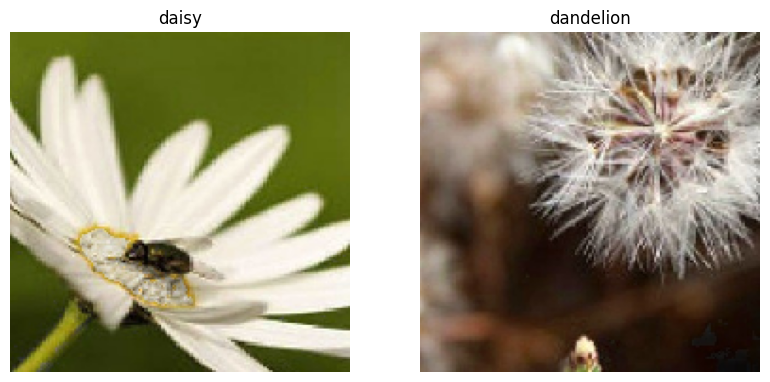

In [47]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=64,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of plants
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

In [48]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,dandelion,746
1,daisy,539


<Axes: xlabel='No. of Image', ylabel='Class'>

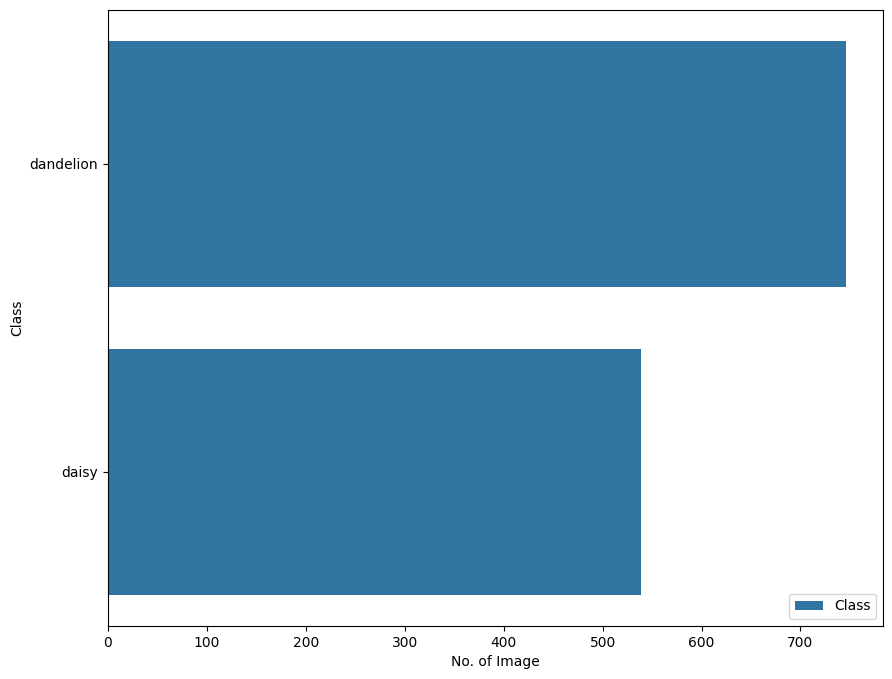

In [49]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8)  )
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

In [29]:
#install Augmentor
# used for generating extra artificial images copied from dataset inorder to increase data training accur.
!pip install Augmentor

In [34]:
# Define the path to the training dataset
path_to_training_dataset = "/content/drive/MyDrive/DataSets/flower_Daisy-Dandalion-Dataset/data/train"

# Define the list of class names (folder names)
class_names = ["daisy", "dandelion"]

# Iterate over each class
for class_name in class_names:
    # Construct the path to the current class
    class_path = os.path.join(path_to_training_dataset, class_name)

    # Create an Augmentor pipeline for the current class
    p = Augmentor.Pipeline(class_path)

    # Add rotation augmentation with certain probabilities and limits
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)

    # Sample 1000 augmented images for each class
    p.sample(1000)


Initialised with 539 image(s) found.
Output directory set to /content/drive/MyDrive/DataSets/flower_Daisy-Dandalion-Dataset/data/train/daisy/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x300 at 0x79E23B9F7730>: 100%|██████████| 1000/1000 [00:24<00:00, 40.06 Samples/s]


Initialised with 746 image(s) found.
Output directory set to /content/drive/MyDrive/DataSets/flower_Daisy-Dandalion-Dataset/data/train/dandelion/output.

Processing <PIL.Image.Image image mode=RGB size=300x300 at 0x79E23BA5B430>: 100%|██████████| 1000/1000 [00:25<00:00, 39.45 Samples/s]


In [42]:
#exceeding aug. cell
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

2000


In [45]:
main_dir = '/content/drive/MyDrive/DataSets/flower_Daisy-Dandalion-Dataset/data'

# Define constants for cropping and enhancement
crop_size = 300  # Size for cropping
saturation_factor = 2.0  # Factor to increase saturation

# Function to process images in a directory
def process_images(directory):
    # Process each file in the directory
    for root, dirs, files in os.walk(directory):
        for filename in files:
            # Read the image
            image_path = os.path.join(root, filename)
            image = cv2.imread(image_path)

            if image is None:
                print(f"Error: Unable to read image '{filename}' in directory '{root}'")
                continue

            # Get dimensions of the image
            height, width = image.shape[:2]

            # Calculate starting and ending coordinates for cropping
            x_start = (width - crop_size) // 2
            y_start = (height - crop_size) // 2

            # Check if the image is large enough for cropping
            if x_start < 0 or y_start < 0:
                print(f"Error: Image '{filename}' in directory '{root}' is too small for cropping")
                continue

            x_end = x_start + crop_size
            y_end = y_start + crop_size

            # Crop the image to 100x100 pixels
            cropped_image = image[y_start:y_end, x_start:x_end]

            # Increase saturation
            hsv_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2HSV)
            hsv_image[:, :, 1] = hsv_image[:, :, 1] * saturation_factor
            saturated_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

            # Overwrite the original image with the enhanced one
            cv2.imwrite(image_path, saturated_image)  # Overwrite with enhanced image

# Apply image processing to train directory
process_images(os.path.join(main_dir, 'train'))

# Apply image processing to test directory
process_images(os.path.join(main_dir, 'test'))

In [50]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=64,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=64,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 3285 files belonging to 2 classes.
Using 2628 files for training.
Found 3285 files belonging to 2 classes.
Using 657 files for validation.


In [51]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.
#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.
#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [52]:
#If you don't want to use a pre-trained ResNet50 model and instead want to define all the layers manually....
# Initialize the Sequential model
# resnet_model = Sequential()

# # Convolutional Layers
# resnet_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(180, 180, 3)))
# resnet_model.add(MaxPooling2D(pool_size=(2, 2)))

# resnet_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# resnet_model.add(MaxPooling2D(pool_size=(2, 2)))

# resnet_model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
# resnet_model.add(MaxPooling2D(pool_size=(2, 2)))

# # Flatten Layer
# resnet_model.add(Flatten())

# # Dense Layers
# resnet_model.add(Dense(512, activation='relu'))
# resnet_model.add(Dense(5, activation='softmax'))  # Output layer with 5 classes

# # Compile the model
# resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Summary of the model
# resnet_model.summary()

#Using pre-traied model layers...
# Initializing the Sequential model Here*
resnet_model = Sequential()

# Load pre-trained ResNet50 model without top layer
pretrained_model = ResNet50(include_top=False, input_shape=(180,180,3), weights='imagenet')
# Freeze all layers in the pre-trained model

for each_layer in pretrained_model.layers:
        each_layer.trainable=False

# Add the pre-trained ResNet50 model to the sequential model

resnet_model.add(pretrained_model)

#Flattern Layer
#Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.

resnet_model.add(Flatten())

#Dense Layer
resnet_model.add(Dense(512, activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
resnet_model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
resnet_model.add(Dense(2, activation='softmax'))
#above code uses the softmax function and creates five neurons to classify the flower classes in the dataset.

# Summary of the model
resnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 73728)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               37749248  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 61337986 (233.99 MB)
Trainable params: 37750274 (144.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


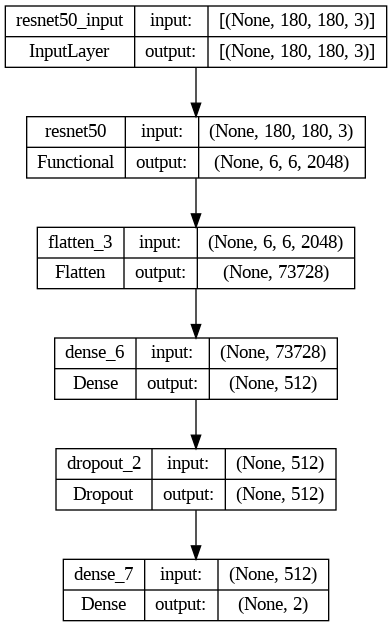

In [53]:
# vizualizing the model
plot_model(resnet_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [55]:
#Compile the Model
#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=10,mode="auto",verbose=1)

In [56]:
# Train the model
history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[checkpoint, earlystop])

Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 7.1388 - accuracy: 0.8527
Epoch 1: val_accuracy improved from -inf to 0.94368, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


42/42 [==============================] - 557s 13s/step - loss: 7.1388 - accuracy: 0.8527 - val_loss: 0.8964 - val_accuracy: 0.9437
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 0.2912 - accuracy: 0.9699
Epoch 2: val_accuracy improved from 0.94368 to 0.96651, saving model to model.h5
42/42 [==============================] - 531s 13s/step - loss: 0.2912 - accuracy: 0.9699 - val_loss: 0.3647 - val_accuracy: 0.9665
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 0.0545 - accuracy: 0.9890
Epoch 3: val_accuracy improved from 0.96651 to 0.96956, saving model to model.h5
42/42 [==============================] - 481s 12s/step - loss: 0.0545 - accuracy: 0.9890 - val_loss: 0.3021 - val_accuracy: 0.9696
Epoch 4/30
42/42 [==============================] - ETA: 0s - loss: 0.0192 - accuracy: 0.9951
Epoch 4: val_accuracy improved from 0.96956 to 0.97412, saving model to model.h5
42/42 [==============================] - 530s 13s/step - loss: 0.0192 - accuracy: 

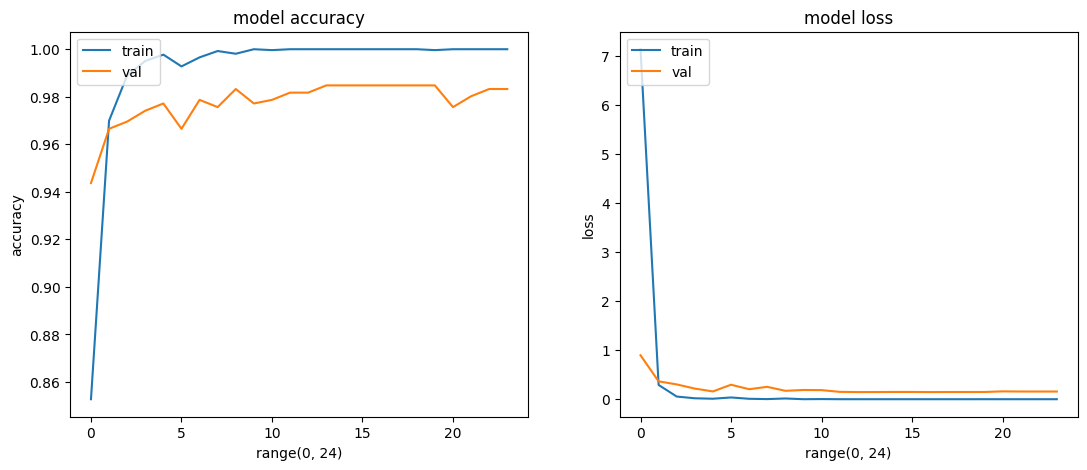

In [57]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(13,5))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 [==============================] - 1s 1s/step
Actual Class : dandelion

Predictive Class : dandelion



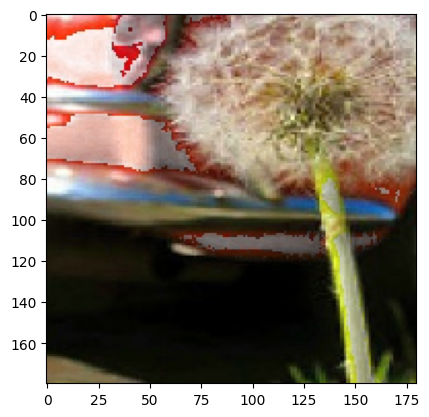

In [58]:

Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = resnet_model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class : "+ class_names[1] +'\n\n'+ "Predictive Class : "+pred_class +'\n' )